In [2]:
import sys

# make sure you are using `eagles` environment
assert sys.executable.split('/')[5]=='eagles'

In [2]:
# Inside this jupyter lab, do not use `pip install xxx`, instead use:
# import sys
# !{sys.executable} -m pip install xxx

In [4]:
# EAGLES package cannot be installed in this environment (eagles)
#!{sys.executable} -m pip show eagles

In [3]:
#so just import from another directory
import sys
sys.path.insert(0, '../EAGLES/')

# Lithium age using eagles
* https://github.com/robdjeff/eagles

Eagles needs `Teff` and `LiEW` or Lithium equivalent width measurement from optical spectra. 

Using `Target.query_vizier_param()`, I compiled useful parameters into a table.

In [4]:
import pandas as pd

data = pd.read_csv('../data/youth_indicators_tois.csv')
data

,TOI,bv,bv_err,li,prot,rhk,teff
0,101.01,0.656000,0.1,NaN,1.430321,NaN,5648.642857
1,102.01,0.507667,0.1,NaN,4.410011,NaN,6257.270417
2,103.01,0.291000,0.1,NaN,3.554638,NaN,6086.159167
3,104.01,0.545667,0.1,NaN,4.090360,NaN,6046.516250
4,105.01,0.687667,0.1,NaN,2.187803,NaN,5741.285333
...,...,...,...,...,...,...,...
4312,5023.01,NaN,NaN,NaN,NaN,NaN,3720.494840
4313,5024.01,0.612000,NaN,NaN,NaN,NaN,5985.393333
4314,5025.01,0.313000,NaN,NaN,NaN,NaN,8132.166667
4315,5026.01,0.700000,NaN,NaN,NaN,NaN,6444.962144


In [5]:
d=data.query("TOI==200.01").squeeze()
d

TOI        200.010000
bv           0.735647
bv_err       0.048146
li         108.107498
prot         5.475000
rhk         -4.090000
teff      5482.444615
Name: 98, dtype: float64

In [6]:
# no measurement errors from vizier so let's assume some values
bv, rhk, li = d.bv, d.rhk, d.li
bv_err, li_err = 0.1, 50
teff_mean, teff_std = d.teff, 100

## EAGLES

In [7]:
import os

# need to change directory for EAGLES to work
os.chdir('../EAGLES/')

https://github.com/robdjeff/eagles/blob/main/eagles.py#L737

## fit

In [9]:
import numpy as np

# for some reason, eagles wants inputs as array
LiEW = np.array([225])
Teff = np.array([5357])
eLiEW = 7
eTeff = 95

In [10]:
from eagles import get_li_age

lAges, llike, lprob, p, chisq = get_li_age(LiEW, eLiEW, Teff, eTeff,
                                           lagesmin=6.0, lagesmax=10.1, 
                                           lApkmin=6.699, nAge=820, z=1.0e-12, nTeff=21, prior=None)

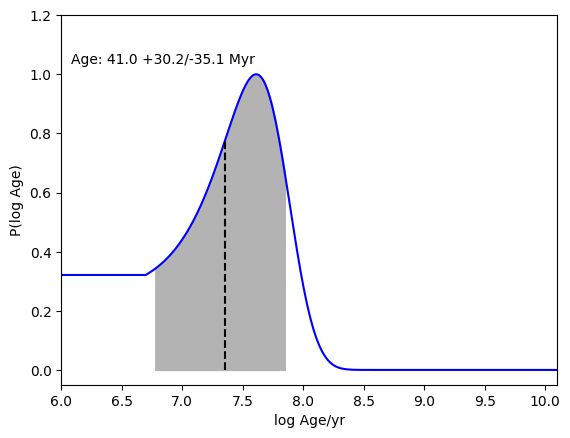

In [11]:
from eagles import make_plots

ID=None
filename=None
lagesmin=6.0
lagesmax=10.1

make_plots(lAges, lprob, p, chisq, lagesmin, lagesmax,
           ID, LiEW, eLiEW, Teff, filename, is_cluster=False, savefig=False)

## plot

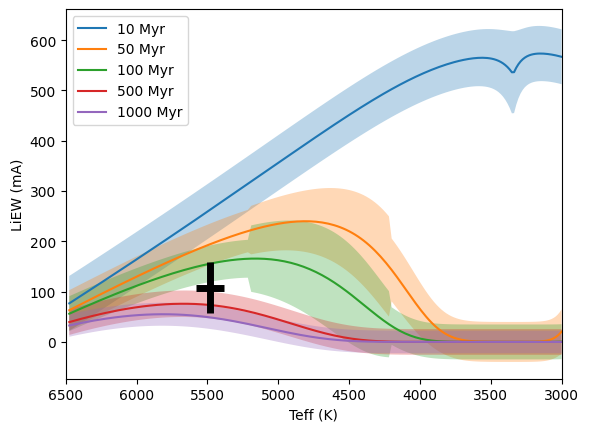

In [14]:
import numpy as np
import matplotlib.pyplot as plt
# import the EWLi prediction model from the main EAGLES code
from eagles import AT2EWm
from eagles import eAT2EWm

# Modify the list below for the isochrones you want to produce (units are Myr)
# ages = [5, 10, 15, 20, 30, 50, 100, 300, 1000, 5000]
ages = [10, 50, 100, 500, 1000]

# e.g. for fewer isochrones
#ages = [10, 100, 1000]

# Modify this flag to true if you want the plot to include the dispersion
# look smessy if there are many closely spaced isochrones
plot_dispersion = True

# The step in logarithmic temperature
tstep = 0.002

# parameters for the plot

fig, ax = plt.subplots()
plt.xlabel('Teff (K)')
plt.ylabel('LiEW (mA)')
ax.set_xlim(6500, 3000)

# set up a an equally spaced set of log temperatures between 3000 and 6500 K
lteff = np.arange(3.4772, 3.8130, tstep)

# loop over the ages
for t in ages :

    lAge = np.log10(t)+6  # log age in years
    ewm = AT2EWm(lteff, lAge)
    eewm = eAT2EWm(lteff, lAge)

    # save the results as a simple .txt file    
    name = 'iso_'+str(t)+'.txt'
    np.savetxt(name, np.column_stack((10**lteff, ewm, eewm)), fmt='%.1f %.1f %.1f', delimiter=' ', header = "Teff(K) EWLim(mA) eEWLi(mA)")
 
    ax.plot(10**lteff, ewm, label='%s Myr' %t)

    # if the plot_dispersion flag then shade the dispersion region
    # looks quite messy if there are lots of isochrones because of the overlap
    if plot_dispersion :
        plt.fill_between(10**lteff, ewm-eewm, ewm+eewm, alpha=0.3)

# For the default list of ages and plot_dispersion = False, this is Fig.2 from the paper    

if len(ages) <6 :
    plt.legend()
else :
    ax.text(0.01,0.95, str(ages)+" Myr", transform=ax.transAxes)

if li is None:
    ax.axvline(teff_mean, c='k', ls='--')
else:
    ax.errorbar(teff_mean, li, yerr=li_err, xerr=teff_std, zorder=10, lw=5, c='k')
    if li<10:
        plt.yscale('log')
        plt.ylim(1e-1, 1e3)

This means given Teff and LiEW of our target star, the probable age is between 100 and 500 Myr.

## Exercise
* Run gyro-interp in all TOI and known host stars in NExSci (see `youth_indicators_nexsci.csv`) 
* Update the TOI and nexsci tables using data from previous research